In [5]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import TopKCategoricalAccuracy

from sklearn.model_selection import train_test_split

In [6]:
from tensorflow.keras.datasets import cifar100

(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Normalize X data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [4]:
model = Sequential([
    Input(shape=(32,32,3)),
    Conv2D(32, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(256, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(100, activation="softmax")
])

2025-04-23 09:34:22.143982: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-23 09:34:22.144501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=25,
    restore_best_weights=True
)

# ModelCheckpoint
checkpoint = ModelCheckpoint(
    "cnn_model.h5",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

X_training, X_val, y_training, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_training.shape, y_training.shape, X_val.shape, y_val.shape )

(37500, 32, 32, 3) (37500, 1) (12500, 32, 32, 3) (12500, 1)


In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [8]:
history = model.fit(
    X_training, y_training,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/100


2025-04-23 09:34:27.202242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-23 09:34:27.415162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


293/293 [==============================] - ETA: 0s - loss: 3.9997 - accuracy: 0.1323

2025-04-23 09:34:47.014382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


293/293 [==============================] - 23s 54ms/step - loss: 3.9997 - accuracy: 0.1323 - val_loss: 5.2130 - val_accuracy: 0.0324 - lr: 0.0010
Epoch 2/100
293/293 [==============================] - 11s 38ms/step - loss: 3.0531 - accuracy: 0.2582 - val_loss: 3.2814 - val_accuracy: 0.2296 - lr: 0.0010
Epoch 3/100
293/293 [==============================] - 11s 37ms/step - loss: 2.5620 - accuracy: 0.3508 - val_loss: 2.5116 - val_accuracy: 0.3687 - lr: 0.0010
Epoch 4/100
293/293 [==============================] - 11s 37ms/step - loss: 2.2332 - accuracy: 0.4142 - val_loss: 2.6705 - val_accuracy: 0.3507 - lr: 0.0010
Epoch 5/100
293/293 [==============================] - 11s 37ms/step - loss: 1.9726 - accuracy: 0.4694 - val_loss: 2.8149 - val_accuracy: 0.3297 - lr: 0.0010
Epoch 6/100
293/293 [==============================] - 11s 37ms/step - loss: 1.7379 - accuracy: 0.5252 - val_loss: 2.9117 - val_accuracy: 0.3360 - lr: 0.0010
Epoch 7/100
293/293 [==============================] - 11s 37ms/

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

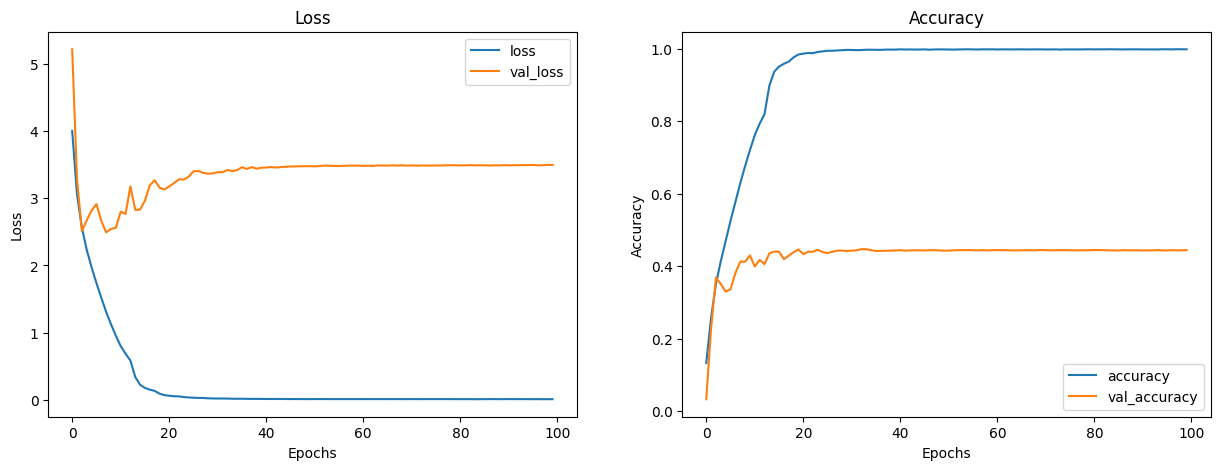

In [10]:
pd.DataFrame({"epoch": history.epoch,
              
              "loss": history.history["loss"],
              "val_loss": history.history["val_loss"],
              "accuracy": history.history["accuracy"],
              "val_accuracy": history.history["val_accuracy"]})

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
from tensorflow.keras.models import load_model
model = load_model("cnn_model.h5")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


2025-04-23 12:26:00.020612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 - 4s - loss: 2.4456 - accuracy: 0.4167 - 4s/epoch - 12ms/step
Test Accuracy: 41.67%
Test Loss: 2.4456


  9/313 [..............................] - ETA: 1s  

2025-04-23 12:26:10.907138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step


/Users/sumitsontakke/Documents/Dev/PES/DL_Practice/mlos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sumitsontakke/Documents/Dev/PES/DL_Practice/mlos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sumitsontakke/Documents/Dev/PES/DL_Practice/mlos/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

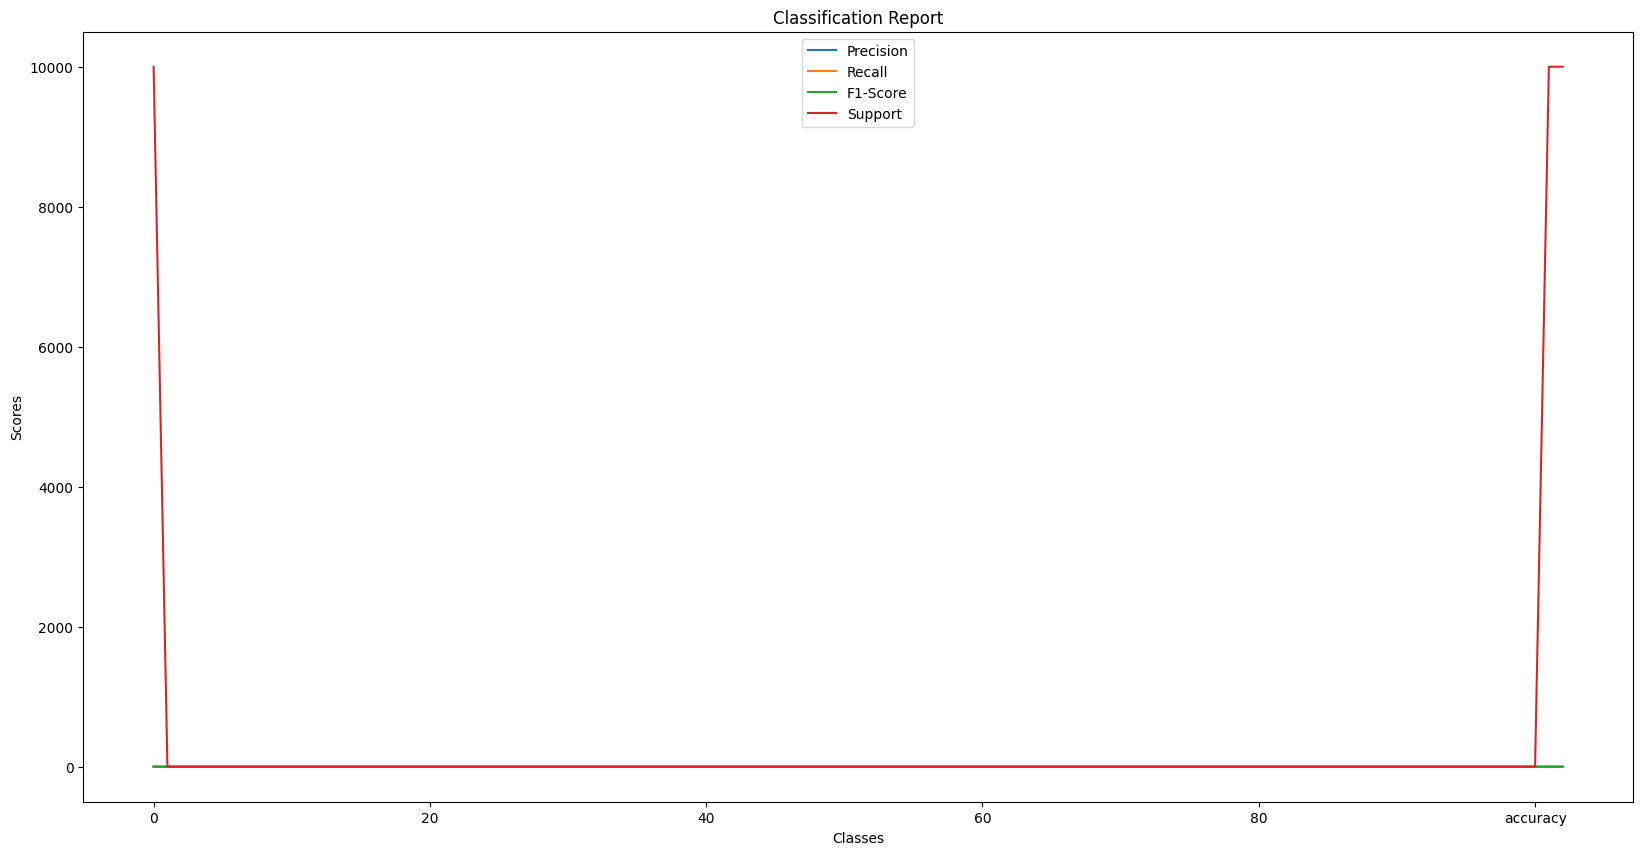

In [8]:
# Get predicted class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
# Print classification report
csr = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Confusion Matrix doesn't help here due to large number of classes.
csr = pd.DataFrame(csr).T
csr = csr.reset_index()
csr.plot(x='index', figsize=(20,10))
plt.title("Classification Report")
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.legend(["Precision", "Recall", "F1-Score", "Support"])
plt.show()

In [9]:
csr.sort_values(by='f1-score', ascending=False, inplace=True)
csr

,index,precision,recall,f1-score,support
0,0,1.0000,0.010700,0.021173,10000.0000
102,weighted avg,1.0000,0.010700,0.021173,10000.0000
100,accuracy,0.0107,0.010700,0.010700,0.0107
101,macro avg,0.0100,0.000107,0.000212,10000.0000
2,2,0.0000,0.000000,0.000000,0.0000
...,...,...,...,...,...
33,33,0.0000,0.000000,0.000000,0.0000
32,32,0.0000,0.000000,0.000000,0.0000
31,31,0.0000,0.000000,0.000000,0.0000
30,30,0.0000,0.000000,0.000000,0.0000
